## Optimization Step 3
This script caculates the number of ammenities. 

1. Create a buffer around each exit 

2. Obtain amenities list from open street map 

3. Calculate # of amenities within each buffer and append the results as a new column 

4. Save the updated exit dataframe as a shp file and visualize the results  

<i>Yiwen Wang | 04/27/2020</i>

### Load exits locations and create buffer area

In [2]:
import geopandas as gpd 
import osmnx as ox 
import shapely
from shapely import speedups
speedups.enabled #check speedups is enabled 

True

In [5]:
#Import the updated safe exit dataset
exits_gdf = gpd.read_file('../Data/MJBA/Exits_distance_to_DCFC.shp')
exits_gdf.crs #Check the crs 

<Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 84°W to 78°W - by country
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
#Create a buffer for each exit with a radius of 1mile
#Buffer circles replace the geometry point column with polygon
exits_gdf['geometry']=exits_gdf['geometry'].buffer(1609.34) #1 mile in meters
exits_gdf['geometry']

0       POLYGON ((199187.352 3880227.389, 199179.602 3...
1       POLYGON ((199427.247 3879713.054, 199419.497 3...
2       POLYGON ((200879.512 3879512.464, 200871.763 3...
3       POLYGON ((202267.978 3879391.092, 202260.229 3...
4       POLYGON ((202751.606 3879923.503, 202743.857 3...
                              ...                        
1173    POLYGON ((727021.121 3919109.433, 727013.371 3...
1174    POLYGON ((747372.602 3934032.757, 747364.852 3...
1175    POLYGON ((575516.833 3963150.415, 575509.083 3...
1176    POLYGON ((516824.775 3963402.749, 516817.026 3...
1177    POLYGON ((370703.899 3911793.401, 370696.150 3...
Name: geometry, Length: 1178, dtype: geometry

In [15]:
#Convert the crs to 4326 to prepare for calculation 
exits_gdf_wgs84 = exits_gdf.to_crs(4326)

#Convert all the polygons into a multipolygon
#create_pois_gdf() requires a single polygon: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.pois
theSearchArea = exits_gdf_wgs84.unary_union 

### Import and prepare amenities dataset

In [16]:
#Obtain amenities geodataframe with attributes from openstreetmap 
#openstreetmap attributes: http://wiki.openstreetmap.org/wiki/Key:amenity
theAmenities = ox.pois.create_poi_gdf(polygon=theSearchArea, amenities=['restaurant','cafe']) 
theAmenities.to_csv('../Data/OSM/Amenities_1mile.csv') #save the geodataframe as csv 

In [19]:
#The obtained amenities list has multiple data type in the geometry column 
theAmenities['geometry'].type.unique()

array(['Point', 'Polygon', 'MultiPolygon'], dtype=object)

In [21]:
#Split amenities according to data types 
theAmenities_points = theAmenities.loc[theAmenities['geometry'].type=='Point'].reset_index()
theAmenities_poly = theAmenities.loc[theAmenities['geometry'].type!='Point'].reset_index()

In [22]:
#Convert polygons to points by representing polygons with their centroids
theAmenities_poly['geometry']=theAmenities_poly['geometry'].centroid

In [23]:
#Merge the two subsets into a new point-only dataframes 
import pandas as pd 
theAmenities_all = pd.concat([theAmenities_points,theAmenities_poly])
theAmenities_all.head()

,index,osmid,geometry,power,element_type,amenity,name,wheelchair,created_by,addr:city,...,product,roof:colour,not:brand:wikidata,branch,note:reservation,FID,alt_name:1,opening_hours:Upstairs_Steamer_Bar,type,ways
0,265610373,265610373,POINT (-78.91902 36.01581),NaN,node,cafe,Joe Van Gogh,yes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,266302295,266302295,POINT (-78.91896 36.01642),NaN,node,restaurant,Watts Grocery,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300269657,300269657,POINT (-78.91903 36.01573),NaN,node,restaurant,Palace International,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,315602700,315602700,POINT (-78.92986 35.92007),NaN,node,restaurant,Bocci,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,315605227,315605227,POINT (-78.92964 35.92044),NaN,node,restaurant,Nantucket,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#Slice Only needed columns and save as shp file
theAmenities_all[['geometry','amenity']].to_file('../Data/OSM/OSM_amenities.shp')

### Count amenities near exits

In [24]:
#Define a function which counts the number of amenities with in 1 mile of each exit
#True = 1 False = 0 
def count_amenities(theArea):
    return theAmenities_all.within(theArea).sum()

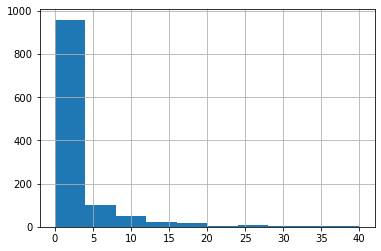

In [26]:
#Apply the function to each exit
amenities_count = exits_gdf_wgs84['geometry'].apply(count_amenities)
amenities_count.hist() #most exits have less than 5 amenities within in 1 mile 

In [28]:
#Append amenities # to the original exit dataframes
exits_gdf = gpd.read_file('../Data/MJBA/Exits_distance_to_DCFC.shp')
exits_gdf['amenities#'] =amenities_count
exits_gdf.head()

,index,FID,Exit_ID,Longitude,Latitude,County,State,Highway,Type,AADT,Pop_dens,Comm_1mi,Ports_5mi,Ports_10mi,Ports_20mi,Close_nonT,Flood_Zone,Dist_to_DC,geometry,amenities#
0,0,7059,US-64_Cherokee_NC_Exit_1,-84.314304,35.019492,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.094152,Area of Minimal Flood Hazard,102,POINT (197578.012 3880227.389),0
1,1,7060,US-64_Cherokee_NC_Exit_2,-84.311492,35.014933,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.365230,Area of Minimal Flood Hazard,102,POINT (197817.907 3879713.054),0
2,2,7061,US-64_Cherokee_NC_Exit_3,-84.295528,35.013561,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,35.233979,Area of Minimal Flood Hazard,102,POINT (199270.172 3879512.464),0
3,3,7062,US-64_Cherokee_NC_Exit_4,-84.280291,35.012880,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.048303,Area of Minimal Flood Hazard,101,POINT (200658.638 3879391.092),0
4,4,7063,US-64_Cherokee_NC_Exit_5,-84.275190,35.017816,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.186597,Area of Minimal Flood Hazard,100,POINT (201142.266 3879923.503),0


In [50]:
#Save the dataframe as a shp file 
exits_gdf.to_file('../Data/MJBA/exits_amenities.shp')

### Visualization

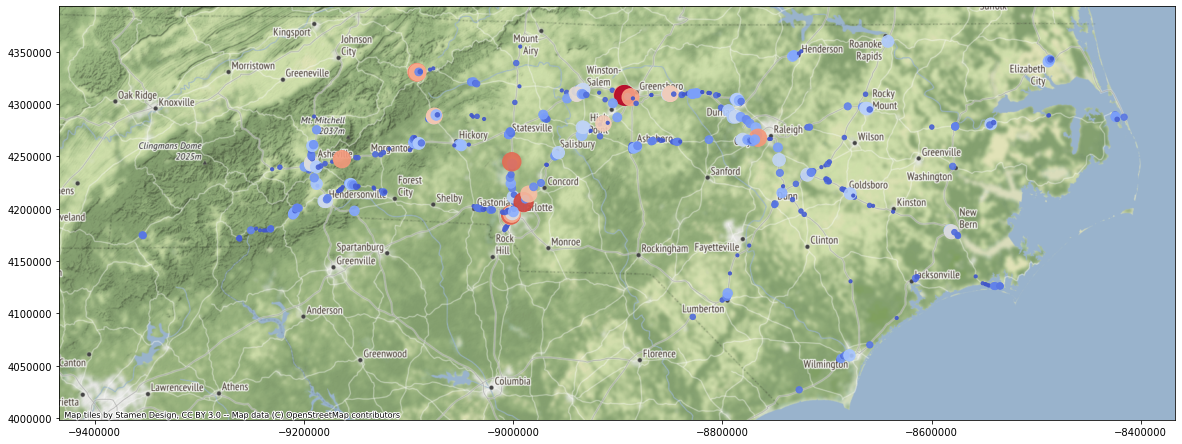

In [43]:
#Visualization method 1
#crs = 3857:  Web Mercator, Google Maps, OpenStreetMap, Bing, ArcGIS, ESRI
import contextily as ctx 

#Plot exits with amenities numbers as markersize 
ax = exits_gdf.to_crs(3857).plot('amenities#',
                                  cmap='coolwarm',
                                  markersize = exits_gdf_wm['amenities#']*10, #type(exits_gdf_wm['amenities#']) series of int
                                  alpha =0.9, #opacity 
                                  figsize = (20,10))
ctx.add_basemap(ax) #basemap in crs = 3857 

In [49]:
#Visualization method 2
#Export the plot as a web map (_map.html) which can be zoomed in/out 
import mplleaflet

#Plot exits with amenities numbers as markersize 
ax_html = exits_gdf.to_crs(4326).plot('amenities#',
                                      cmap='coolwarm',
                                      markersize = exits_gdf_wm['amenities#']*10,
                                      alpha =0.9,
                                      figsize = (20,10))
mplleaflet.show(fig=ax_html.figure)